In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# importing necessary libraries

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms,datasets
import torch.nn as nn
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# dataset to my path in google drive

In [19]:
dataset_path = '/content/drive/MyDrive/KaggleDatasets/Tea_Sickness_Dataset/tea sickness dataset'

In [20]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# transforming data

In [21]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),              # Resize to desired dimensions
    transforms.RandomHorizontalFlip(),         # Apply horizontal flip
    transforms.RandomVerticalFlip(),           # Apply vertical flip
    transforms.RandomInvert(),                 # Invert colors
    transforms.RandomRotation(degrees=90),     # Randomly rotate 90 degrees
    transforms.ToTensor(),                     # Convert PIL image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize tensor
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),             # Resize for validation
    transforms.ToTensor(),                     # Convert PIL image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize tensor
])


# Making separate directories for storing training, testing, validation photos

In [22]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import os
import shutil

# make specific directories
base_dir='/content/drive/MyDrive/KaggleDatasets/Tea_Sickness_Dataset/Split'
train_dir=os.path.join(base_dir,'train')
val_dir=os.path.join(base_dir,'val')
test_dir=os.path.join(base_dir,'test')

#make directories if not present
os.makedirs(train_dir,exist_ok=True)
os.makedirs(val_dir,exist_ok=True)
os.makedirs(test_dir,exist_ok=True)


# Splitting the dataset into separate directories for each class of disease

In [23]:
#This for loop is to connect all the subdirectory present in the tea sickness dataset to disease_path

for disease_folder in os.listdir(dataset_path):
  disease_path=os.path.join(dataset_path,disease_folder)

  if not os.path.isdir(disease_path):        #if there is no such directory then just continue and don't stop the loop
    continue

  images=os.listdir(disease_path)            #copy all the images

  # splitting the dataset into training (70% ), testing(15%) and validation(15%)
  train_images,test_images=train_test_split(images,test_size=0.3,random_state=42)
  val_images,test_images=train_test_split(test_images,test_size=0.5,random_state=42)

  # creating subdirectories for each disease(like anthracnose,algal leaf) in train,test and val directories

  train_disease_dir=os.path.join(train_dir,disease_folder)
  val_disease_dir=os.path.join(val_dir,disease_folder)
  test_disease_dir=os.path.join(test_dir,disease_folder)

  os.makedirs(train_disease_dir,exist_ok=True)
  os.makedirs(val_disease_dir,exist_ok=True)
  os.makedirs(test_disease_dir,exist_ok=True)

  # move the splitted images to these respective directories of train,test and val

  for image in train_images:
    shutil.copy(os.path.join(disease_path,image),os.path.join(train_disease_dir,image))

  for image in val_images:
    shutil.copy(os.path.join(disease_path,image),os.path.join(val_disease_dir,image))

  for image in test_images:
    shutil.copy(os.path.join(disease_path,image),os.path.join(test_disease_dir,image))

def countfiles(directory):
  count=0
  for root,dirs,files in os.walk(directory):
      count += len(files)
  return count

print("Training set size:", countfiles(train_dir))
print("Testing set size:", countfiles(test_dir))
print("Validation set size:", countfiles(val_dir))


Training set size: 618
Testing set size: 135
Validation set size: 132


# ImageFolder helps in loading the images in batches

In [24]:
from torchvision.datasets import ImageFolder

train_data=ImageFolder(root=train_dir,transform=train_transforms)
val_data=ImageFolder(root=val_dir,transform=val_transforms)
test_data=ImageFolder(root=test_dir,transform=val_transforms)

In [25]:
train_loader= DataLoader(train_data,batch_size=32,shuffle=True)
val_loader=DataLoader(val_data,batch_size=32,shuffle=False)
test_loader=DataLoader(test_data,batch_size=32,shuffle=False)

# Hyperparameters defined

In [26]:
#hyperparameters
batch_size=32
num_epochs=8
Learning_rate=0.001

# Making a class of ResNET50 with no.of output neurons as 8

In [27]:
# Define ResNet50 model for classification
from torchvision import models

#Define ResNET50 classifier

class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=8):
        super(ResNet50Classifier, self).__init__()
        self.resnet = models.resnet50(weights=None)
        self.resnet.fc= nn.Linear(2048, num_classes)

    def forward(self,x):
      return self.resnet(x)

# tqdm for progress bar

In [7]:
pip install tqdm

# setting the ResNet50 classifier to model and passing the model to device's cpu for training

In [28]:
model = ResNet50Classifier(num_classes=8)
model = model.to(device)

## Defining the Loss function and Optimizer

In [29]:
#Using crossentropy loss for multi class classification
criterion = nn.CrossEntropyLoss()
#using Adam optimizer for optimizing the loss function.
optimizer = optim.Adam(model.parameters(),lr=Learning_rate)

# Defining a train function with loss as crossentropy and optimizer as Adam,such that whenever we write model.train(), then the resnet50 will start training with crossentropy loss and will optimize with Adam optimizer

In [30]:
def train(model,train_loader,val_loader,num_epochs=num_epochs,device=device):
  criterion=nn.CrossEntropyLoss()
  optimizer=optim.Adam(model.parameters(),lr=Learning_rate)

   # Track metrics
  train_loss, val_loss = [], []
  train_accuracy, val_accuracy = []
  precision_scores, recall_scores, f1_scores = [], [], []


# Training the model for num_epochs=8 . The training loss is decreasing but the validation loss is not increasing frequently.

In [20]:
from tqdm import tqdm
# Initialize metrics
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [] , []
precision_scores, recall_scores, f1_scores = [], [], []
#  training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0.0
    correct_train = 0
    total_train = 0

    # tqdm progress bar
    loop = tqdm(train_loader, total=len(train_loader), leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update metrics
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        # Update tqdm description
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    # Training statistics
    train_loss.append(epoch_loss / len(train_loader))
    train_accuracy.append(100 * correct_train / total_train)

    # Validation Loop
    model.eval()  # Set model to evaluation mode
    val_epoch_loss = 0.0
    correct_val = 0
    total_val = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Validation metrics
    val_loss.append(val_epoch_loss / len(val_loader))
    val_accuracy.append(100 * correct_val / total_val)
    precision_scores.append(precision_score(all_labels, all_preds, average='weighted', zero_division=1))
    recall_scores.append(recall_score(all_labels, all_preds, average='weighted',  zero_division=1))
    f1_scores.append(f1_score(all_labels, all_preds, average='weighted',  zero_division=1))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.2f}%")



Epoch 1/8, Train Loss: 2.1970, Val Loss: 6.0740, Val Accuracy: 12.88%


Epoch 2/8, Train Loss: 1.3748, Val Loss: 1.8320, Val Accuracy: 38.64%


Epoch 3/8, Train Loss: 1.1950, Val Loss: 2.0083, Val Accuracy: 34.85%


Epoch 4/8, Train Loss: 1.3314, Val Loss: 2.7357, Val Accuracy: 26.52%


Epoch 5/8, Train Loss: 1.2616, Val Loss: 1.2206, Val Accuracy: 48.48%


Epoch 6/8, Train Loss: 1.0888, Val Loss: 0.9549, Val Accuracy: 59.09%


Epoch 7/8, Train Loss: 1.1372, Val Loss: 1.3943, Val Accuracy: 40.15%


Epoch 8/8, Train Loss: 1.0427, Val Loss: 1.9841, Val Accuracy: 34.85%


# saving the model weights in .pth file

In [21]:
torch.save(model.state_dict(), 'tea_disease_model.pth')

# saving the model weights in .pth file in my google drive

In [26]:
torch.save(model.state_dict(), '/content/drive/MyDrive/KaggleDatasets/Tea_Sickness_Dataset/tea_disease_model.pth')


# Loading the model's prelearned weights from the .pth file stored in google drive

In [32]:
model.load_state_dict(torch.load('/content/drive/MyDrive/KaggleDatasets/Tea_Sickness_Dataset/tea_disease_model.pth'))

   # The warning shown below in this cell's output is a warning from pytorch for safety reasons , as I am loading a saved model's weights. It may happen sometimes while loading some unknown model weights which may be malicious.

<ipython-input-32-941010da1792>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/KaggleDatasets/Tea_Sickness_Dataset

<All keys matched successfully>

# Improving the validation accuracy and reducing the training loss, as in previous training loop the validation accuracy was around 40%. This training loop is started from the previous training loop where it was stopped  i.e., from epoch 9 to epoch 18 (additional 10 epochs added) with a reduced learning rate.

In [33]:
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import torch

# Update number of epochs for additional training
additional_epochs = 10
num_epochs += additional_epochs

# Reduce the learning rate for fine-tuning
for param_groups in optimizer.param_groups:
    param_groups['lr'] = 0.0001

print(f"Resuming training for {additional_epochs} more epochs with learning rate: {param_groups['lr']}")

# Early stopping parameters
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

# Continue training
for epoch in range(num_epochs - additional_epochs, num_epochs):  # Adjust epoch range
    model.train()  # Set model to training mode
    epoch_loss = 0.0
    correct_train = 0
    total_train = 0

    # tqdm progress bar for training
    loop = tqdm(train_loader, total=len(train_loader), leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update metrics
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        # Update tqdm description
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    # Training statistics
    train_loss.append(epoch_loss / len(train_loader))
    train_accuracy.append(100 * correct_train / total_train)

    # Validation Loop
    model.eval()  # Set model to evaluation mode
    val_epoch_loss = 0.0
    correct_val = 0
    total_val = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Validation metrics
    val_loss.append(val_epoch_loss / len(val_loader))
    val_accuracy.append(100 * correct_val / total_val)
    precision_scores.append(precision_score(all_labels, all_preds, average='weighted', zero_division=1))
    recall_scores.append(recall_score(all_labels, all_preds, average='weighted', zero_division=1))
    f1_scores.append(f1_score(all_labels, all_preds, average='weighted', zero_division=1))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.2f}%")

    # Early stopping logic
    if val_loss[-1] < best_val_loss:
        best_val_loss = val_loss[-1]
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save the updated best model
        print(f"Validation loss improved. Model saved.")
    else:
        epochs_no_improve += 1

    if epochs_no_improve == patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break


Resuming training for 10 more epochs with learning rate: 0.0001


Epoch 9/18, Train Loss: 0.8623, Val Loss: 0.8896, Val Accuracy: 62.88%
Validation loss improved. Model saved.


Epoch 10/18, Train Loss: 0.7664, Val Loss: 1.2963, Val Accuracy: 50.00%


Epoch 11/18, Train Loss: 0.7743, Val Loss: 1.3487, Val Accuracy: 50.00%


Epoch 12/18, Train Loss: 0.7773, Val Loss: 2.6204, Val Accuracy: 37.88%
Early stopping triggered after 12 epochs.


In [34]:
torch.save(model.state_dict(), '/content/drive/MyDrive/KaggleDatasets/Tea_Sickness_Dataset/tea_disease_model(12 EPOCH).pth')

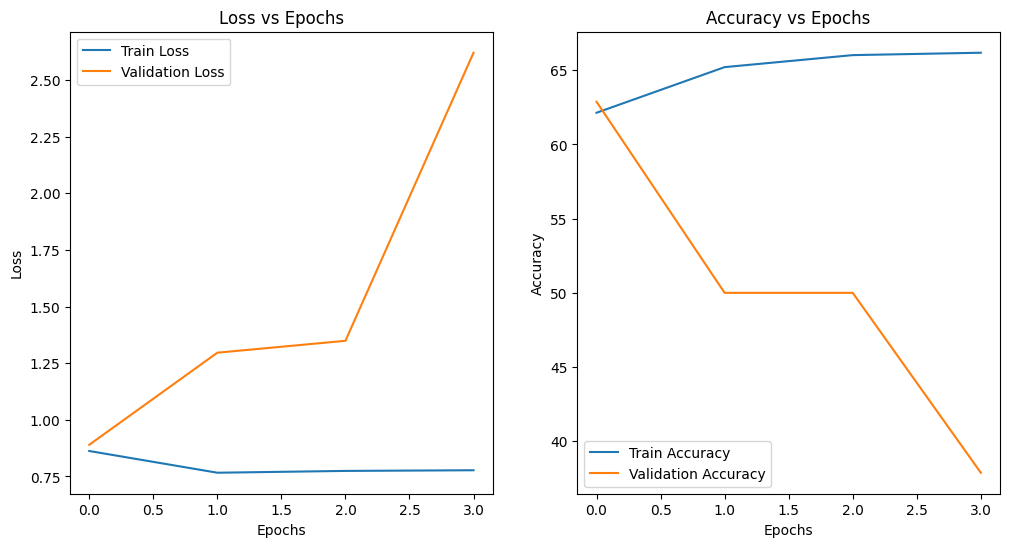

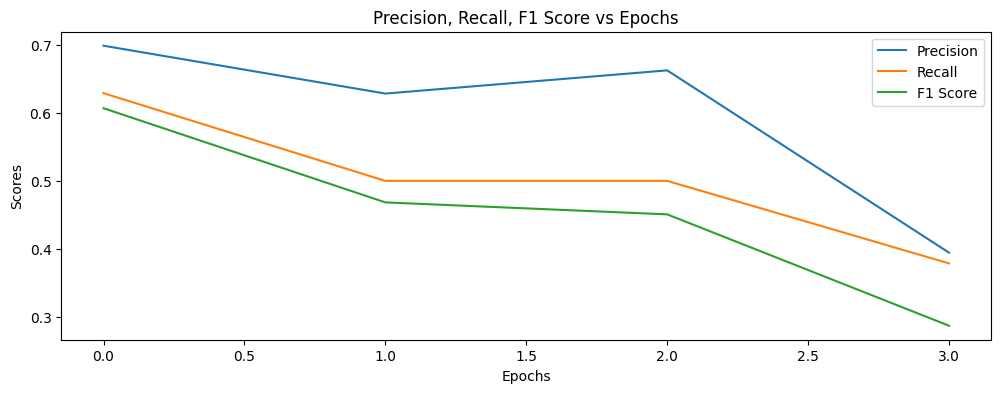

In [37]:
def plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy, precision, recall, f1):
    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()
    plt.show()

    # Plot Precision, Recall, F1-Score
    plt.figure(figsize=(12, 4))
    plt.plot(precision, label='Precision')
    plt.plot(recall, label='Recall')
    plt.plot(f1, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Scores')
    plt.title('Precision, Recall, F1 Score vs Epochs')
    plt.legend()
    plt.show()

plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy, precision_scores, recall_scores, f1_scores)



In [36]:
# Define the DataLoader for the test set (assuming you've already prepared it)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Evaluate the model on the test set
all_labels = []
all_preds = []

with torch.no_grad():  # No need to calculate gradients during evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Collecting all labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 35.56%
